Entropy of dataset: 4.459431618637296
Gini Index of dataset: 0.9545454545454546
Best Feature (Root Node): humidity | Info Gain: 1.566837323312348
Equal-width binning (N): [2, 2, 1, 2, 2, 1, 1, 2, 2, 1]
Frequency binning (N): [3, 3, 2, 2, 2, 2, 2, 3, 3, 2]
Custom Decision Tree (root feature index): 4
Decision Tree Accuracy: 0.865909090909091


/tmp/ipython-input-1740547547.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return 1 - np.sum(p**2 for p in probabilities)


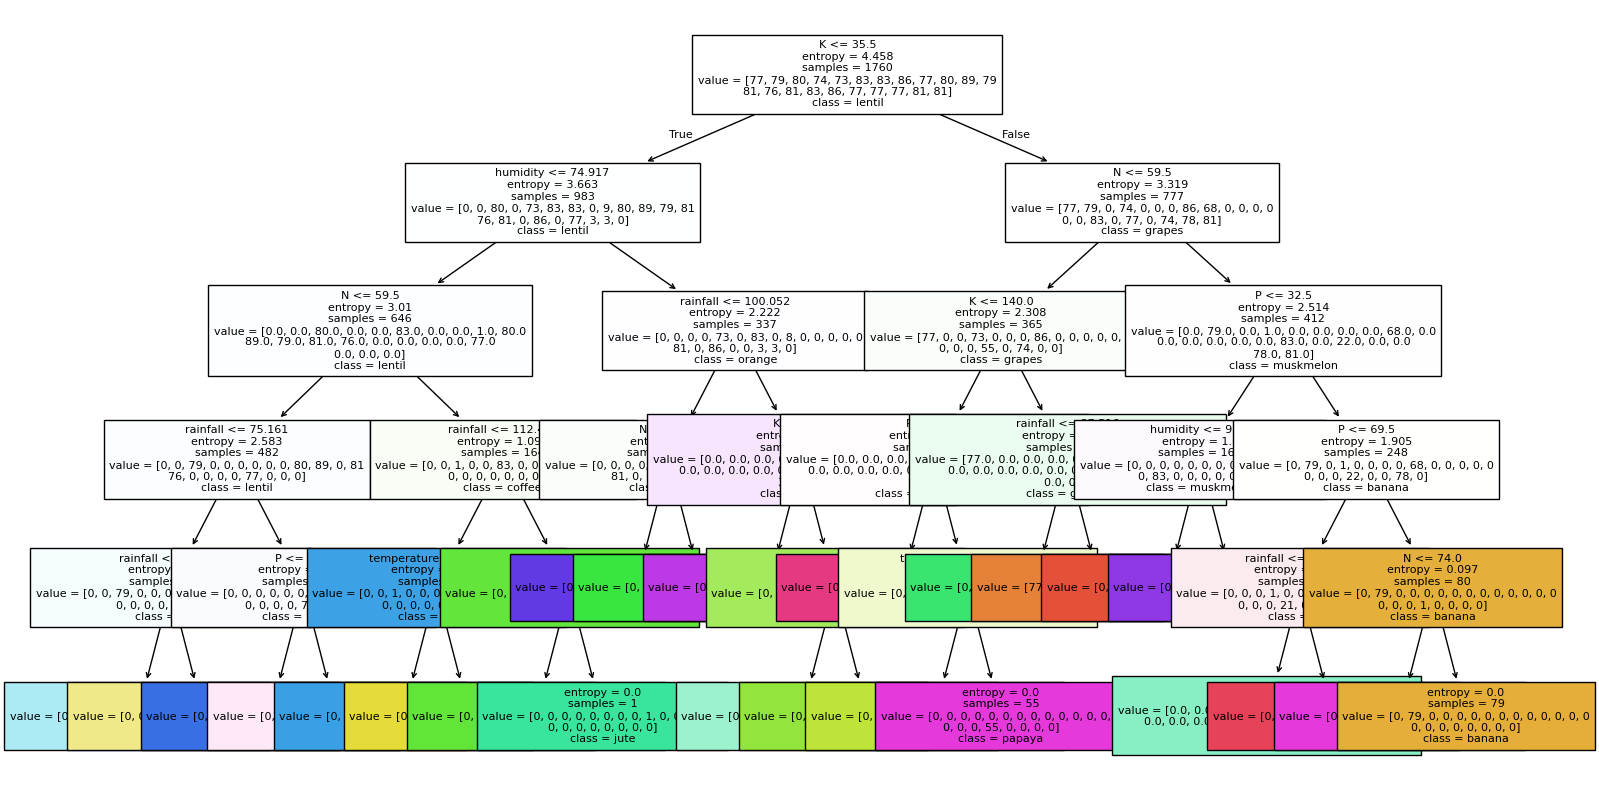

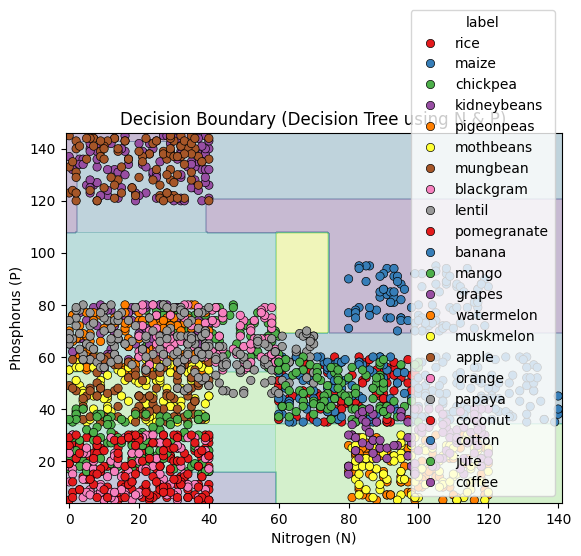

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter

# --------------------------
# Load Dataset
# --------------------------
df = pd.read_csv("/Crop_recommendation lab-6.csv")

X = df.drop("label", axis=1).values
y = df["label"].astype("category").cat.codes  # encode crop labels
class_names = df["label"].astype("category").cat.categories

# --------------------------
# A1. Entropy + Equal Width Binning
# --------------------------
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

def equal_width_binning(data, bins=4):
    return pd.cut(data, bins=bins, labels=False)

print("Entropy of dataset:", entropy(y))

# --------------------------
# A2. Gini Index
# --------------------------
def gini_index(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum(p**2 for p in probabilities)

print("Gini Index of dataset:", gini_index(y))

# --------------------------
# A3. Information Gain & Best Feature
# --------------------------
def information_gain(y, X_col):
    parent_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(y[X_col == v])
                               for i, v in enumerate(values)])
    return parent_entropy - weighted_entropy

def best_feature(X, y):
    gains = [information_gain(y, pd.qcut(X[:, i], q=4, duplicates="drop", labels=False))
             for i in range(X.shape[1])]
    return np.argmax(gains), max(gains)

best_feat, best_gain = best_feature(X, y)
print("Best Feature (Root Node):", df.columns[best_feat], "| Info Gain:", best_gain)

# --------------------------
# A4. Continuous Feature Binning (Equal-width / Frequency)
# --------------------------
def binning(data, bins=4, method="equal_width"):
    if method == "equal_width":
        return pd.cut(data, bins=bins, labels=False)
    elif method == "frequency":
        return pd.qcut(data, q=bins, labels=False, duplicates="drop")
    else:
        raise ValueError("Invalid method: choose 'equal_width' or 'frequency'")

# Example usage:
print("Equal-width binning (N):", binning(df["N"].values, bins=4, method="equal_width")[:10].tolist())
print("Frequency binning (N):", binning(df["N"].values, bins=4, method="frequency")[:10].tolist())

# --------------------------
# A5. Build Simple Decision Tree (Recursive)
# --------------------------
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(X, y, depth=0, max_depth=3):
    if len(set(y)) == 1:
        return DecisionTreeNode(value=y[0])
    if depth >= max_depth:
        return DecisionTreeNode(value=Counter(y).most_common(1)[0][0])

    feat_idx, _ = best_feature(X, y)
    threshold = np.median(X[:, feat_idx])
    left_idx = X[:, feat_idx] <= threshold
    right_idx = X[:, feat_idx] > threshold

    left_child = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
    right_child = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)

    return DecisionTreeNode(feature=feat_idx, threshold=threshold, left=left_child, right=right_child)

root = build_tree(X, y, max_depth=3)
print("Custom Decision Tree (root feature index):", root.feature)

# --------------------------
# A6. Decision Tree Visualization (using sklearn)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf.fit(X_train, y_train)

print("Decision Tree Accuracy:", clf.score(X_test, y_test))

plt.figure(figsize=(18,10))
plot_tree(clf, feature_names=df.columns[:-1], class_names=class_names, filled=True, fontsize=8)
plt.show()

# --------------------------
# A7. Decision Boundary (2 features only: N & P)
# --------------------------
X_2 = df[["N", "P"]].values
y_2 = y

clf2 = DecisionTreeClassifier(max_depth=4)
clf2.fit(X_2, y_2)

x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
sns.scatterplot(x=X_2[:, 0], y=X_2[:, 1], hue=df["label"], palette="Set1", edgecolor="k")
plt.xlabel("Nitrogen (N)")
plt.ylabel("Phosphorus (P)")
plt.title("Decision Boundary (Decision Tree using N & P)")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')